In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from albumentations import Compose, Resize, HorizontalFlip, RandomBrightnessContrast, GaussNoise
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
from torchmetrics import Accuracy, Precision, Recall, F1Score

import warnings
warnings.filterwarnings('ignore')

Exploring structure and nomenclature

Classes: ['non shop lifters', 'shop lifters']


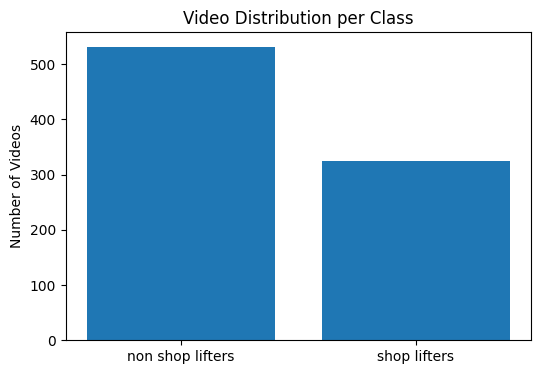

{'non shop lifters': 531, 'shop lifters': 324}


In [2]:
data_root = "/kaggle/input/shop-dataset/Shop DataSet"

classes = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))])
print("Classes:", classes)


def count_videos_per_class(root):
    counter = {}
    for cls in classes:
        cls_path = os.path.join(root, cls)
        vids = [f for f in os.listdir(cls_path) if f.lower().endswith(('.mp4', '.avi'))]
        counter[cls] = len(vids)

    # Visualization
    plt.figure(figsize=(6,4))
    plt.bar(counter.keys(), counter.values())
    plt.ylabel('Number of Videos')
    plt.title('Video Distribution per Class')
    plt.show()
    
    return counter

print(count_videos_per_class(data_root))

 Preprocessing & Augmentation

In [3]:
# Example of preparing a spatial transform for each frame
spatial_transform = Compose([
    Resize(112, 112),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.3),

], p=1.0)

Dataset class with sampling and length standardization

In [4]:
class TheftVideoDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames=16, transform=None, mode=None):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.transform = transform  # spatial transform per frame
        self.mode = mode  # "train", "val", "test"

    def __len__(self):
        return len(self.video_paths)

    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames

    def _sample_frames(self, frames):
        total = len(frames)
        if total >= self.num_frames:
            if self.mode == "train":
                # Random consecutive sampling
                start = np.random.randint(0, total - self.num_frames + 1)
                sampled = frames[start:start + self.num_frames]
            else:
                # Uniform sampling
                indices = np.linspace(0, total - 1, self.num_frames, dtype=int)
                sampled = [frames[i] for i in indices]
        else:
            pad = [frames[-1]] * (self.num_frames - total)
            sampled = frames + pad
        return sampled

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = self.labels[idx]
        frames = self._load_video(path)
        
        if len(frames) == 0:
            raise RuntimeError(f"Failed to load video: {path}")

        # Apply temporal dropout only during training
        if self.mode == "train":
            frames = self._temporal_dropout(frames, drop_prob=0.2)
            
        frames = self._sample_frames(frames)  # list of HxWxC

        processed = []
        for f in frames:
            if self.transform:
                augmented = self.transform(image=f)
                f_proc = augmented["image"]  # tensor CxHxW if ToTensorV2 used
            else:
                f_resized = cv2.resize(f, (112, 112))
                f_proc = torch.from_numpy(f_resized).permute(2,0,1).float() / 255.0
            processed.append(f_proc)

        video_tensor = torch.stack(processed)  # shape: (T, C, H, W)
        video_tensor = video_tensor.permute(1,0,2,3)  # (C, T, H, W) for 3D CNN consistency
        return video_tensor, torch.tensor(label, dtype=torch.long)

    def _temporal_dropout(self, frames, drop_prob=0.2):
        keep = [f for f in frames if np.random.rand() > drop_prob]
        if len(keep) < self.num_frames:
            pad = [keep[-1]] * (self.num_frames - len(keep))
            keep += pad
        return keep[:self.num_frames]

Building models from scratch

1. 3D CNN Simplified

In [5]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),
            
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),
            
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1,1,1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):  # x: (B, C, T, H, W)
        x = self.features(x)
        x = self.classifier(x)
        return x

class CNNEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Linear(128, embed_dim)

    def forward(self, x):  # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.conv(x)  # (B*T, 128, 1,1)
        x = x.view(B * T, -1)  # (B*T, 128)
        x = self.fc(x)  # (B*T, embed_dim)
        x = x.view(B, T, -1)
        return x  # (B, T, embed_dim)

2. CNN + RNN

In [6]:
class CNN_RNN(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=2):
        super().__init__()
        self.encoder = CNNEncoder(embed_dim=256)
        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):  # x: (B, T, C, H, W)
        seq = self.encoder(x)  # (B, T, 256)
        out, _ = self.lstm(seq)  # (B, T, hidden_dim)
        last = out[:, -1, :]  # (B, hidden_dim)
        logits = self.classifier(last)
        return logits

3. Transformer

In [7]:
class VideoTransformer(nn.Module):
    def __init__(self, cnn_embed_dim=512, n_heads=4, n_layers=2, hidden_dim=256, num_classes=2, dropout=0.1):
        super(VideoTransformer, self).__init__()

        # CNN backbone
        resnet = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
        self.cnn_fc = nn.Linear(resnet.fc.in_features, cnn_embed_dim)

        # Positional encoding for frames
        self.pos_embedding = nn.Parameter(torch.randn(1, 100, cnn_embed_dim))

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cnn_embed_dim,
            nhead=n_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Classification head
        self.cls_token = nn.Parameter(torch.randn(1, 1, cnn_embed_dim))
        self.classifier = nn.Linear(cnn_embed_dim, num_classes)

    def forward(self, x):  # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        features = self.cnn(x)  # (B*T, 512, 1, 1)
        features = features.view(B, T, -1)  # (B, T, 512)
        features = self.cnn_fc(features)  # (B, T, cnn_embed_dim)

        # Add cls token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, cnn_embed_dim)
        tokens = torch.cat([cls_tokens, features], dim=1)  # (B, T+1, cnn_embed_dim)

        # Add positional encoding
        tokens = tokens + self.pos_embedding[:, :tokens.size(1), :]  # (B, T+1, cnn_embed_dim)

        x = self.transformer(tokens)  # (B, T+1, cnn_embed_dim)
        cls_out = x[:, 0]  # Take output of cls token
        return self.classifier(cls_out)  # (B, num_classes)

TRAINING & EVALUATION

In [8]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    num_batches = len(loader)

    all_preds = []
    all_labels = []

    for batch_idx, (videos, labels) in enumerate(loader):
        videos = videos.float().to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(videos)
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predictions & labels for metrics
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        # Print progress
        if batch_idx % 10 == 0:
            print(f'  Batch [{batch_idx}/{num_batches}] Loss: {loss.item():.4f}')

    # Calculate metrics
    avg_loss = total_loss / num_batches
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1

def evaluate(model, loader, criterion, device):
    model.eval()

    # Initialize metrics
    acc_metric = Accuracy(task="multiclass", num_classes=2).to(device)
    prec_metric = Precision(task="multiclass", average='macro', num_classes=2).to(device)
    recall_metric = Recall(task="multiclass", average='macro', num_classes=2).to(device)
    f1_metric = F1Score(task="multiclass", average='macro', num_classes=2).to(device)

    total_loss = 0.0

    with torch.no_grad():
        for videos, labels in loader:
            videos = videos.float().to(device)
            labels = labels.to(device)

            logits = model(videos)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)

            # Update metrics
            acc_metric.update(preds, labels)
            prec_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_metric.update(preds, labels)

    return {
        "loss": total_loss / len(loader),
        "accuracy": acc_metric.compute().item(),
        "precision": prec_metric.compute().item(),
        "recall": recall_metric.compute().item(),
        "f1": f1_metric.compute().item()
    }


DATA PREPARATION

In [9]:
def prepare_data(data_root, test_size=0.3, val_size=0.5, random_state=42):
    class_names = ["non shop lifters", "shop lifters"]
    label_map = {name: idx for idx, name in enumerate(class_names)}

    # Collect video paths and labels
    video_paths = []
    labels = []

    for cls in class_names:
        cls_dir = os.path.join(data_root, cls)
        if not os.path.isdir(cls_dir):
            raise FileNotFoundError(f"Directory not found: {cls_dir}")

        for video_file in glob.glob(os.path.join(cls_dir, "*")):
            if video_file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
                video_paths.append(video_file)
                labels.append(label_map[cls])

    print(f"Found {len(video_paths)} videos total")
    print(f"Class distribution: {Counter(labels)}")

    # Stratified split
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        video_paths, labels, stratify=labels, test_size=test_size, random_state=random_state
    )

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, stratify=temp_labels, test_size=val_size, random_state=random_state
    )

    print(f"Data split - Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

    return (train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels)

def create_balanced_sampler(labels):
    class_sample_count = np.bincount(labels)
    weights = 1.0 / class_sample_count
    sample_weights = [weights[label] for label in labels]
    return WeightedRandomSampler(sample_weights, num_samples=len(labels), replacement=True)

def create_transforms():
    train_transform = Compose([
        Resize(112, 112),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.3),
        ToTensorV2(),
    ], p=1.0)

    val_transform = Compose([
        Resize(112, 112),
        ToTensorV2(),
    ], p=1.0)

    return train_transform, val_transform

def create_dataloaders(train_data, val_data, test_data, train_transform, val_transform,
                       num_frames=16, batch_size=4, num_workers=2):

    train_paths, train_labels = train_data
    val_paths, val_labels = val_data
    test_paths, test_labels = test_data

    # Create datasets
    train_dataset = TheftVideoDataset(train_paths, train_labels, num_frames, train_transform, mode="train")
    val_dataset = TheftVideoDataset(val_paths, val_labels, num_frames, val_transform, mode="val")
    test_dataset = TheftVideoDataset(test_paths, test_labels, num_frames, val_transform, mode="test")

    # Create balanced sampler for training set
    sampler = create_balanced_sampler(train_labels)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,
                             num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

In [10]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='b')
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='m')
    plt.xlabel("Epochs");
    plt.ylabel("Loss");
    plt.legend();
    plt.title("Loss")

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy', color='b')
    plt.plot(epochs, history['val_accuracy'], label='Val Accuracy', color='m')
    plt.xlabel("Epochs");
    plt.ylabel("Accuracy");
    plt.legend();
    plt.title("Accuracy")

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1', color='b')
    plt.plot(epochs, history['val_f1'], label='Val F1', color='m')
    plt.xlabel("Epochs");
    plt.ylabel("F1 Score");
    plt.legend();
    plt.title("F1 Score")

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in dataloader:
            videos = videos.float().to(device)
            labels = labels.to(device)

            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix & F1
    cm = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, pos_label=1)

    # Plot
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (F1 Score: {f1:.4f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

MAIN TRAINING FUNCTION

In [11]:
def train_model(data_root, model_name="Simple3DCNN", num_epochs=50, learning_rate=1e-4,
                batch_size=4, num_frames=16, patience=7):

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Prepare data
    train_data, val_data, test_data = prepare_data(data_root)
    train_transform, val_transform = create_transforms()
    train_loader, val_loader, test_loader = create_dataloaders(
        train_data, val_data, test_data, train_transform, val_transform,
        num_frames, batch_size
    )

    # Calculate class weights
    train_paths, train_labels = train_data
    counter = Counter(train_labels)
    class_names = ["non shop lifters", "shop lifters"]
    class_counts = [counter[i] for i in range(len(class_names))]
    weights = torch.tensor([1.0 / c if c > 0 else 0.0 for c in class_counts])
    weights = weights / weights.max()
    print(f"Class weights: {weights}")

    # Initialize model
    if model_name == "Simple3DCNN":
        
        model = Simple3DCNN(num_classes=2).to(device)
    elif model_name == "CNN_RNN":
        model = CNN_RNN(num_classes=2).to(device)
    elif model_name == "Transformer":
        model = VideoTransformer(num_classes=2).to(device)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Setup training components
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

    # Training history
    history = {
        'train_loss': [], 'train_accuracy': [], 'train_f1': [],
        'val_loss': [], 'val_accuracy': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    best_f1 = 0.0

    print(f"\nStarting training for {num_epochs} epochs...")
    print("="*60)

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        print("-" * 30)

        # Training phase
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)

        # Validation phase
        val_metrics = evaluate(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_metrics["loss"])
        current_lr = optimizer.param_groups[0]['lr']

        # Update history
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['train_f1'].append(train_f1)
        
        history['val_loss'].append(val_metrics["loss"])
        history['val_accuracy'].append(val_metrics["accuracy"])
        history['val_precision'].append(val_metrics["precision"])
        history['val_recall'].append(val_metrics["recall"])
        history['val_f1'].append(val_metrics["f1"])

        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}")
        print(f"Val Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Val F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")

        # Save best model
        if val_metrics["f1"] > best_f1:
            best_f1 = val_metrics["f1"]
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
                'history': history
            }, "best_model.pth")
            print(f">>> New best model saved! F1: {best_f1:.4f}")

        # Early stopping check
        if early_stopping(val_metrics["loss"], model):
            print(f"Early stopping triggered after {epoch} epochs")
            break

    # Load best model for testing
    checkpoint = torch.load("best_model.pth", weights_only = False)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Final evaluation on test set
    print("\n" + "="*60)
    print("FINAL EVALUATION ON TEST SET")
    print("="*60)

    test_metrics = evaluate(model, test_loader, criterion, device)
    print("Test Results:")
    for key, value in test_metrics.items():
        print(f"  {key.capitalize()}: {value:.4f}")

    # Visualize evolution
    plot_training_history(history)

    # Plot Confusion matrix
    plot_confusion_matrix(model, test_loader, class_names, device)
    
    return model, history, test_metrics

PREDICTION FUNCTION

In [12]:
def predict_video(model, video_path, transform, num_frames=16, device='cpu', class_names=None):
    """Predict the class of a single video"""
    if class_names is None:
        class_names = ["non shop lifters", "shop lifters"]

    # Create temporary dataset with dummy label
    dataset = TheftVideoDataset([video_path], [0], num_frames=num_frames, transform=transform)
    video_tensor, _ = dataset[0]
    video_tensor = video_tensor.unsqueeze(0).float().to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        logits = model(video_tensor)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs.max().item()

    return {
        'prediction': class_names[pred],
        'confidence': confidence,
        'probabilities': probs.squeeze().cpu().tolist()
    }

Using device: cuda
Found 855 videos total
Class distribution: Counter({0: 531, 1: 324})
Data split - Train: 598, Val: 128, Test: 129
Class weights: tensor([0.6119, 1.0000])

Starting training for 50 epochs...

Epoch 1/50
------------------------------
  Batch [0/150] Loss: 0.6886
  Batch [10/150] Loss: 0.7151
  Batch [20/150] Loss: 0.7341
  Batch [30/150] Loss: 0.7360
  Batch [40/150] Loss: 0.7803
  Batch [50/150] Loss: 0.6177
  Batch [60/150] Loss: 0.5657
  Batch [70/150] Loss: 0.6992
  Batch [80/150] Loss: 0.7564
  Batch [90/150] Loss: 0.7189
  Batch [100/150] Loss: 0.6332
  Batch [110/150] Loss: 0.7329
  Batch [120/150] Loss: 0.5478
  Batch [130/150] Loss: 0.5819
  Batch [140/150] Loss: 0.6254
Train Loss: 0.6816 | Train Accuracy: 0.5067 | Train F1: 0.4634
Val Loss: 0.6900
Val Accuracy: 0.3750
Val F1: 0.2727
Learning Rate: 0.000100
>>> New best model saved! F1: 0.2727

Epoch 2/50
------------------------------
  Batch [0/150] Loss: 0.7429
  Batch [10/150] Loss: 0.7375
  Batch [20/150

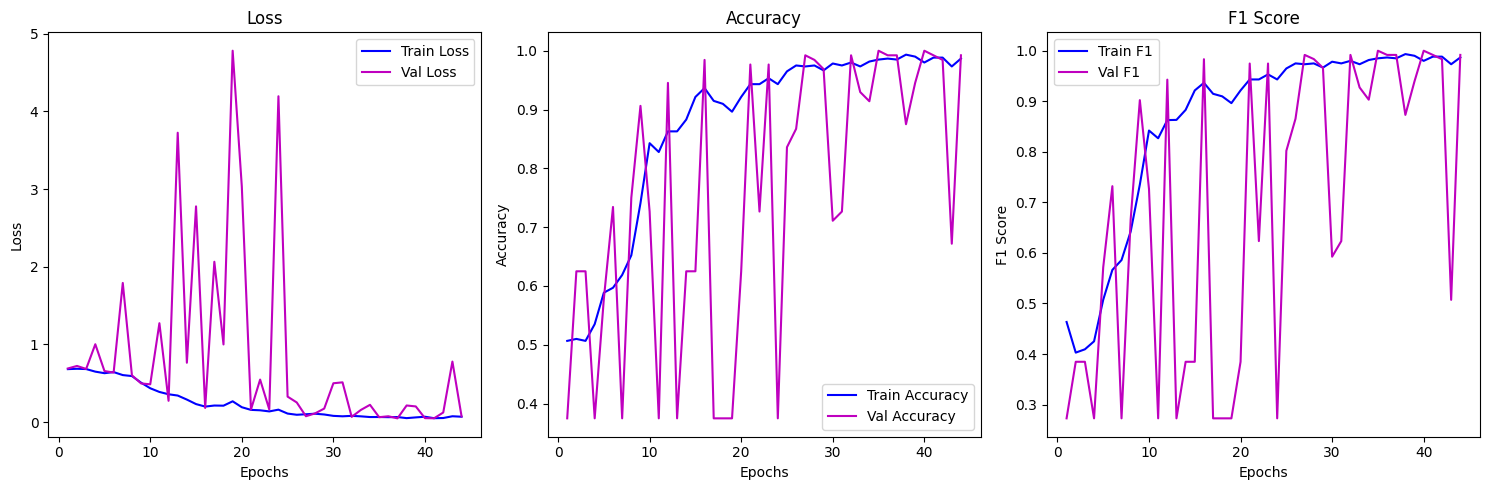

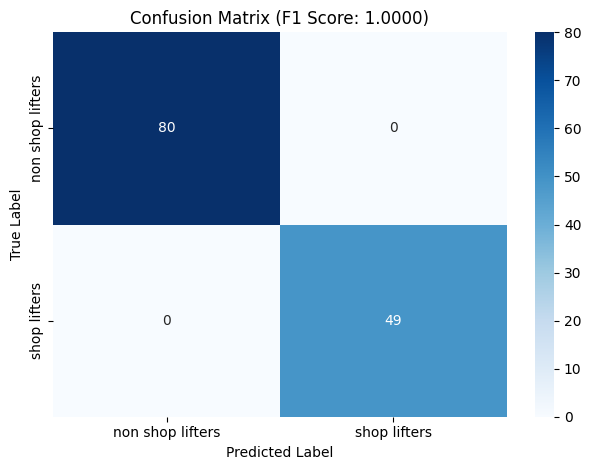

In [13]:
if __name__ == "__main__":
    # Configuration
    DATA_ROOT = "/kaggle/input/shop-dataset/Shop DataSet"
    MODEL_NAME = "Simple3DCNN"

    # Training parameters
    config = {
        'num_epochs': 50,
        'learning_rate': 1e-4,
        'batch_size': 4,
        'num_frames': 16,
        'patience': 7
    }

    try:
        # Train the model
        model, history, test_metrics = train_model(DATA_ROOT, MODEL_NAME, **config)

    except Exception as e:
        print(f"Error: {e}")

In [37]:
# Configuration
DATA_ROOT = "/kaggle/input/shop-dataset/Shop DataSet"
MODEL_NAME = "CNN_RNN"

# Training parameters
config = {
    'num_epochs': 50,
    'learning_rate': 1e-4,
    'batch_size': 4,
    'num_frames': 16,
    'patience': 7
}

try:
    # Train the model
    model, history, test_metrics = train_model(DATA_ROOT, MODEL_NAME, **config)

except Exception as e:
    print(f"Error: {e}")

Using device: cuda
Found 855 videos total
Class distribution: Counter({0: 531, 1: 324})
Data split - Train: 598, Val: 128, Test: 129
Class weights: tensor([0.6119, 1.0000])

Starting training for 50 epochs...

Epoch 1/50
------------------------------
  Batch [0/150] Loss: 0.6515
  Batch [10/150] Loss: 0.8523
  Batch [20/150] Loss: 0.5962
  Batch [30/150] Loss: 0.8148
  Batch [40/150] Loss: 0.6636
  Batch [50/150] Loss: 0.4651
  Batch [60/150] Loss: 0.5565
  Batch [70/150] Loss: 0.7496
  Batch [80/150] Loss: 0.7187
  Batch [90/150] Loss: 0.7132
  Batch [100/150] Loss: 0.6817
  Batch [110/150] Loss: 0.6486
  Batch [120/150] Loss: 0.6745
  Batch [130/150] Loss: 0.6032
  Batch [140/150] Loss: 0.6745
Train Loss: 0.6912
Val Loss: 0.7046
Val Accuracy: 0.3750
Val F1: 0.2727
Learning Rate: 0.000100
>>> New best model saved! F1: 0.2727

Epoch 2/50
------------------------------
  Batch [0/150] Loss: 0.6743
  Batch [10/150] Loss: 0.7939
  Batch [20/150] Loss: 0.7276
  Batch [30/150] Loss: 0.6301

In [20]:
import torchvision
# Configuration
DATA_ROOT = "/kaggle/input/shop-dataset/Shop DataSet"
MODEL_NAME = "Transformer"

# Training parameters
config = {
    'num_epochs': 50,
    'learning_rate': 1e-4,
    'batch_size': 4,
    'num_frames': 16,
    'patience': 7
}

try:
    # Train the model
    model, history, test_metrics = train_model(DATA_ROOT, MODEL_NAME, **config)

except Exception as e:
    print(f"Error: {e}")

Using device: cuda
Found 855 videos total
Class distribution: Counter({0: 531, 1: 324})
Data split - Train: 598, Val: 128, Test: 129
Class weights: tensor([0.6119, 1.0000])

Starting training for 50 epochs...

Epoch 1/50
------------------------------
  Batch [0/150] Loss: 0.5415
  Batch [10/150] Loss: 0.3419
  Batch [20/150] Loss: 0.3943
  Batch [30/150] Loss: 0.0199
  Batch [40/150] Loss: 0.1183
  Batch [50/150] Loss: 0.1068
  Batch [60/150] Loss: 0.0390
  Batch [70/150] Loss: 0.1535
  Batch [80/150] Loss: 0.0949
  Batch [90/150] Loss: 0.5750
  Batch [100/150] Loss: 0.4312
  Batch [110/150] Loss: 0.0478
  Batch [120/150] Loss: 0.0034
  Batch [130/150] Loss: 0.8165
  Batch [140/150] Loss: 0.3257
Train Loss: 0.3237
Val Loss: 0.2642
Val Accuracy: 0.9453
Val F1: 0.9419
Learning Rate: 0.000100
>>> New best model saved! F1: 0.9419

Epoch 2/50
------------------------------
  Batch [0/150] Loss: 0.0218
  Batch [10/150] Loss: 0.1321
  Batch [20/150] Loss: 0.0061
  Batch [30/150] Loss: 0.0177